## 필요한 데이터 불러오기 및 접근

## 필요한 라이브러리 설치

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
%cd /content/drive/My Drive/nlp_liflow/

/content/drive/My Drive/nlp_liflow


In [26]:
!ls

자연어처리_1.ipynb		  nlp_tokenizer.ipynb
자연어처리_2.ipynb		  스포츠_sen.csv
all_df_with_tokens.csv		  sen_preprocessig.csv
all_sen.csv			  스포츠_sen_prerprocessing.csv
cc.ko.300.bin.gz		  sentence_Summarizer.ipynb
df_all				  textrank
df_all.csv			  textrank_git
first_embedding_clustering.model  자연어처리_tomotopy_HDPModel.ipynb
item_1.csv			  자연어처리_tomotopy.ipynb
item_all.csv			  자연어처리_tomotopy_modeling.ipynb
ko.bin				  word2vec_model
list_to_csv.csv


In [4]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2022-11-11 11:48:42--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-11-11 11:48:42--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc37072c2ab6bd1a378cf833d356.dl.dropboxusercontent.com/cd/0/get/Bwhtq2Uo2W57hcKBPXHyFGW7en-Op8slSwIwKmh8FYxRE8CKMSzAVEVgwxAWuu62DnKb7fpyMrp9NtMd-xsQLam64NNhCcDNG8kmylkoZBbZGlD6dqc3Vt8B3BJiTmhsrueg0FbD9ZBcssuMS6YHCa3EJcsO9cE4vH94iWLA8Zq9fUTxYx3YjN9jmv1vYitQ0po/file?dl=1# [following]
--2022-11-11 11:48:43--  https://uc37072c2ab6bd1a378cf833d356.dl.dropboxusercontent.com/cd/0/get/Bwhtq2Uo2W57

In [5]:
!pip install kss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42.4 MB 1.3 MB/s 
     |████████████████████████████████| 131 kB 38.8 MB/s 
  Created wheel for kss: filename=kss-3.6.4-py3-none-any.whl size=42448613 sha256=38ae27944d176b150f2659fedcff75ab9c89a7cdd7da0610937e4b1f3e58cb51
  Stored in directory: /root/.cache/pip/wheels/32/53/7c/76bdf098c2a6c5cd4c4c29648da30ad4793d604314b2aeb26f
Successfully built kss


In [6]:
import textrank_git
from textrank_git import rank
from textrank_git import sentence
from textrank_git import summarizer
from textrank_git import utils
from textrank_git import word
import re
import kss
import pandas as pd
from konlpy.tag import Mecab
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim import models
import gensim
import logging
import os
from collections import namedtuple, defaultdict
from collections.abc import Iterable
from timeit import default_timer
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
from dataclasses import dataclass
from numpy import zeros, float32 as REAL, vstack, integer, dtype
import numpy as np
from gensim import utils, matutils  # utility fnc for pickling, common scipy operations etc
from gensim.utils import deprecated
from gensim.models import Word2Vec # noqa: F401
from gensim.models.keyedvectors import KeyedVectors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

## 원본 대화(스포츠)의 키워드 추출하기
key_textrank는 원문 키워드를 말하며

해당 과정은 textrank를 사용해 추출되었습니다.

이 작업은 추후에 doc2vec을 사용해 군집분석을 진행할 때 사용될 단어 리스트를 추리는 작업입니다.

In [175]:
import csv
key_textrank = []
with open('/content/drive/MyDrive/nlp_liflow/sen_preprocessig.csv', 'r', encoding='utf-8') as f:
    a = csv.reader(f)
    list_of_csv = list(a)
    for i in list_of_csv:
      key_textrank.append((i[1][2:-2]))


In [176]:
mecab = Mecab()
stopwords = ['우리']
def tokenizer(raw, pos=["NNG","NNP","VV","VA"], stopword=stopwords): 
  return [word for word, tag in mecab.pos(raw) if len(word) > 1 and tag in pos and word not in stopword ]
key_textrank = key_textrank[1::]

In [177]:
token = []
for i in key_textrank:
  token.append(tokenizer(i))

In [178]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import re
import numpy as np
from scipy.sparse.dia import dia_matrix
import joblib

In [179]:
def partial_fit(self, X):
    max_idx = max(self.vocabulary_.values())
    for a in X:
        # update vocabulary_
        tokens = tokenizer(a)
        for w in tokens:
            if w not in self.vocabulary_:
                max_idx += 1    
                self.vocabulary_[w] = max_idx

        # update idf_
        df = (self.n_docs + self.smooth_idf) / \
            np.exp(self.idf_ - 1) - self.smooth_idf
        self.n_docs += 1
        df.resize(len(self.vocabulary_))
        for w in tokens:
            df[self.vocabulary_[w]] += 1
        idf = np.log((self.n_docs + self.smooth_idf) /
                     (df + self.smooth_idf)) + 1
        self._tfidf._idf_diag = dia_matrix(
            (idf, 0), shape=(len(idf), len(idf)))

In [197]:
tf = TfidfVectorizer(
    stop_words=stopwords, tokenizer=tokenizer, ngram_range=(1, 2), max_features=500, sublinear_tf=True)
matrix= tf.fit_transform(key_textrank)
tf.n_docs = len(key_textrank)
with open("feature.pkl", "wb") as fw:
    pickle.dump(matrix, fw)
with open("vectorizer.pkl", "wb") as fw:
    pickle.dump(tf, fw)

In [96]:
#데이터가 추가 되었을 때
TfidfVectorizer.partial_fit = partial_fit
tf = TfidfVectorizer(
    stop_words=stopwords, tokenizer=tokenizer, ngram_range=(1, 2), max_features=200, sublinear_tf=True)
matrix= tf.fit_transform(key_textrank)
tf.n_docs = len(key_textrank)
more = ["수영이 좋아 수영은 물속에 있는 거라서 그렇게 힘들지 않거든",'골프가 좋아']
tf.partial_fit(more)
tf.transform(more).toarray()

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [ ]:
doc_vec = pd.DataFrame(columns=['convrs','trained_vector','token'])

for text, i, t in zip(key_textrank,matrix.toarray(),token):
  new_row = pd.DataFrame([[text,i,t]],columns =  doc_vec.columns)
  doc_vec = pd.concat([doc_vec, new_row], ignore_index = True)
  print(f"text: {text}, tokens: {t}")
  print(f"trained_doc_vec: {i}")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.48198091 0.38027928
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         

In [ ]:
doc_vec

## PCA

In [187]:
feature=[]
for i in range(0,100):
    a = "feature"+str(i)
    feature.append(a)
# 1500 개의 주성분으로 차원 축소
pca = PCA(n_components= 100) 
printcipalComponents = pca.fit_transform(matrix.toarray())

principalDf = pd.DataFrame(data=printcipalComponents, columns = feature)

In [188]:
pca.explained_variance_ratio_

array([0.03235526, 0.0224665 , 0.02151905, 0.01972968, 0.01812736,
       0.01766443, 0.01695907, 0.01646652, 0.01597778, 0.0150564 ,
       0.01439805, 0.01407399, 0.01380681, 0.01329179, 0.01298411,
       0.01275506, 0.01243075, 0.012208  , 0.01217986, 0.01126036,
       0.01100968, 0.01072997, 0.01049486, 0.01026685, 0.01001665,
       0.00980081, 0.0096235 , 0.00927129, 0.00906592, 0.00890066,
       0.00859591, 0.0083959 , 0.0082335 , 0.00820727, 0.00802362,
       0.00770883, 0.00761686, 0.0074713 , 0.0072755 , 0.00695175,
       0.00685283, 0.00676088, 0.0066202 , 0.00653605, 0.00639382,
       0.00627343, 0.00613608, 0.006088  , 0.00599257, 0.00590073,
       0.00582783, 0.00573171, 0.00569928, 0.00565721, 0.00559255,
       0.00547272, 0.00536586, 0.0052622 , 0.00520559, 0.00511888,
       0.00506058, 0.00502419, 0.00490862, 0.00487468, 0.00485548,
       0.00479453, 0.0047438 , 0.00467567, 0.00459602, 0.00455059,
       0.00449452, 0.00444672, 0.00441802, 0.00433147, 0.00430

In [189]:
sum(pca.explained_variance_ratio_)

0.9830335747094381

In [190]:
# 2차원으로 축소
n_components = 2

# t-SNE 모델 생성
tsne = TSNE(n_components = n_components)

# 학습한 결과 2차원 공간값 출력
tsnedata = tsne.fit_transform(principalDf)

print(tsnedata)
column = ['x', 'y']
tsnedata = pd.DataFrame(tsnedata, columns = column)

doc_vec['tsne_x'] = tsnedata['x']
doc_vec['tsne_y'] = tsnedata['y']

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[[-1.64601078e+01 -7.25621796e+00]
 [ 1.39759016e+01 -8.81355476e+00]
 [-1.61453171e+01  3.34497666e+00]
 [ 2.47110033e+00  1.46918859e+01]
 [-2.08459892e+01 -8.23455715e+00]
 [-4.49319744e+00  1.34834595e+01]
 [-1.45080481e+01  5.30138397e+00]
 [-1.46878462e+01  3.98196006e+00]
 [-1.25798769e+01 -9.58379650e+00]
 [ 1.65185146e+01 -5.38765335e+00]
 [-1.93796616e+01 -1.00558109e+01]
 [ 8.87513542e+00  1.30695562e+01]
 [-3.71876881e-02 -1.81121933e+00]
 [-1.37354374e+01 -1.02335520e+01]
 [-1.43209238e+01 -2.58874083e+00]
 [-2.80105686e+00  4.88122559e+00]
 [ 1.30085154e+01 -5.60914613e-02]
 [ 1.18378382e+01 -1.42710867e+01]
 [-3.63182712e+00  1.43014078e+01]
 [ 1.04890728e+01  9.92689323e+00]
 [ 1.11275589e+00  2.00366259e-01]
 [-2.01009598e+01  9.68285751e+00]
 [ 1.71318188e+01 -9.78487301e+00]
 [ 1.79574013e+01  9.10759640e+00]
 [ 9.72833347e+00 -1.64457912e+01]
 [-1.49646544e+00 -2.17558217e+00]
 [-3.77143121e+00 -4.78752470e+00]
 [ 1.51933432e+01 -1.01468306e+01]
 [-1.75714111e+01  6

In [191]:
doc_vec

,convrs,trained_vector,token,tsne_x,tsne_y
0,감탄을 금치 못할 이야기도 나오고 그래 또 나는 축구에 대해 얘기하고 싶네참 오래된...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0932188066840...","[감탄, 이야기, 나오, 축구, 얘기, 얘기, 과거, 서독, 프로, 축구, 차범근,...",-16.460108,-7.256218
1,강도도 제일 센 걸로 했는데 위에서 이렇게 딱 꺼내 보니까 직전이야 주민센터 그쪽에...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.137...","[강도, 직전, 주민, 센터, 이용, 다음, 스쿼시, 다음, 수영, 순위, 자전거,...",13.975902,-8.813555
2,같이 일선발이 나와서 이렇게 게임을 했는데 일회 하고 이회 시작할 때 비가 엄청 오...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[선발, 게임, 이회, 시작, 평소, 기아, 타이거즈, 그날, 하루, 즐겁, 하루,...",-16.145317,3.344977
3,거의 십년 전이니까 그 당시만해도 골프가 대중적인 스포츠는 아니었으요 그래서 몇 명...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[당시, 골프, 대중, 스포츠, 조금, 마음, 상황, 계룡산, 근처, 탁구, 어렵,...",2.471100,14.691886
4,골프 치려면은 또 돈이 많아야 되는데 한국에 돈 많은 사람이 되게 많은가 보다 싶기...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[골프, 한국, 사람, 만들, 한골, 성장, 나라, 여자, 수구, 나라, 중학생, ...",-20.845989,-8.234557
...,...,...,...,...,...
223,한시간쯤 지나니까 얼굴이 빨개져서 들어왔네그러더니 스쿼트를 했대그러면 땀으로 목욕을...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[시간, 지나, 얼굴, 쿼트, 목욕, 해외여행, 마음, 요가, 힘들, 도전, 욕심,...",18.403238,-11.246835
224,할 줄 아는 것이 일단은 그거잖아우리 나이도 있어서 오래는 못 하지근데 사실 나이를...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[나이, 오래, 나이, 수록, 운동, 다치, 친구, 동창, 그러, 얘기, 친구, 골...",0.015504,2.887926
225,항상 운동 전에 수분 섭취를 해야돼그래서 나는 러닝머신 스피드를 육 점 영 정도 놓...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[운동, 수분, 섭취, 러닝, 머신, 스피드, 정도, 힘들, 시작, 스로, 기구, ...",16.247665,-5.081139
226,해 보니까 근육이 파열돼서 피가 나오는 바람에 고생하고 있거든그러면 고전 무용 말고...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[근육, 파열, 나오, 고생, 고전, 무용, 수영, 한국, 무용, 운동, 무리, 첫...",9.709212,-0.374410


## 군집화 진행해보기
시도해 볼 cluster 수는 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20 개 입니다.

### Elbow curve 
Cluster 간의 거리의 합을 나타내는 inertia가 급격히 떨어지는 구간이 생기는데 이 구간을 확인해 최적 군집 개수를 구하고자 합니다.


### silhouette score
군집 타당성 지표인 silhouette score를 사용해 적정 군집을 확인해 볼 예정입니다.

### Elbow curve


############################################################
K-Means Clustering
############################################################


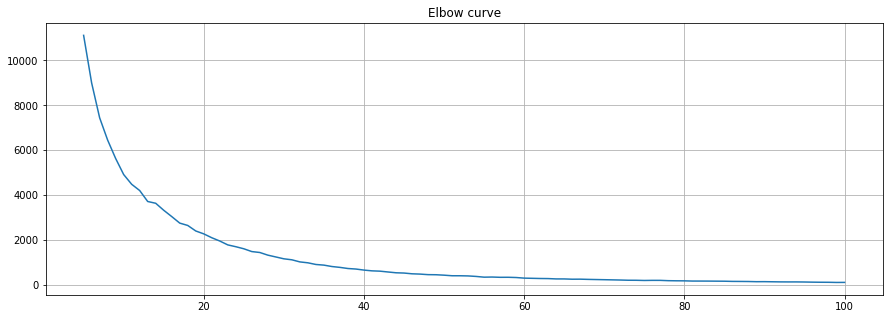

In [192]:
print("##"*30)
print("K-Means Clustering")
print("##"*30)
# 시도해 볼 cluster 수
cluster_number = range(5,101)
distortions = []
processed_data = tsnedata.copy()
scaler = preprocessing.MinMaxScaler()
scaler.fit_transform(processed_data[['x', 'y']])

# 모델 학습
for k in cluster_number:
    Clustering_Method = KMeans(n_clusters=k, random_state = 0)
    #X = model.docvecs.vectors_docs 
    Clustering_Method.fit(processed_data)
    distortions.append(Clustering_Method.inertia_)
    
# Elbow Curve 시각화
fig = plt.figure(figsize=(15, 5))
plt.plot(cluster_number, distortions)
plt.grid(True)
plt.title('Elbow curve')
plt.show()

### K_means 사용한 clustering 결과

In [193]:
from math import*
def euclidean_distance(x, y):
    return sqrt(sum(pow(a - b, 2) for a, b in zip(x, y)))

In [194]:
doc_vec['trained_vector'][0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.09321881, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.12767564, 0.        , 0.     

In [196]:
Clustering_Method = KMeans(n_clusters=10, random_state=0)
X = matrix.toarray() # document vector 전체를 가져옴. 
Clustering_Method.fit(processed_data)# fitting 

#Clustering_Method.cluster_centers_
cluster_dict = {i:[] for i in range(0, 10)}
for text, label in zip(range(len(doc_vec)), Clustering_Method.labels_):
    a = []
    a.append(doc_vec['convrs'].loc[text])
    a.append([doc_vec['tsne_x'].loc[text],doc_vec['tsne_y'].loc[text]])
    a.append([doc_vec['token'].loc[text]])
    a.append([doc_vec['trained_vector'].loc[text]])
    cluster_dict[label].append(a)

item_all = pd.DataFrame(columns = ['cluster','convrs','vec','x','y','distance','token'])

for label, lst in cluster_dict.items():
    item = pd.DataFrame(columns = ['cluster','convrs','vec','x','y','distance','token'])
    print(f"Cluster {label}")
    for x , y in zip(lst, Clustering_Method.cluster_centers_):
        print(x[0])
        token = str(x[2])
        vec = str(x[3])
        distance = euclidean_distance(x[1],y)
        new_df = pd.DataFrame({'cluster':label,
                               'vec': vec,
                               'token': token,
                              'convrs':x[0],
                               'x': x[1][0],
                               'y': x[1][1],
                               'distance': distance},index = [0])
        item = pd.concat([item,new_df], ignore_index = True)
    item = item.sort_values('distance')
    item_all = pd.concat([item_all,item], ignore_index = True)
    
    print("--"*30)
print("##"*20)

Cluster 0
강도도 제일 센 걸로 했는데 위에서 이렇게 딱 꺼내 보니까 직전이야 주민센터 그쪽에서 이용해서 하면 저렴하기도 한데 일단 제일 하고 싶은 건 줌바 줌바 그다음에 스쿼시 그다음에 이제 수영인데 사실 순위는 자전거지더 전에 하면 좋겠는데 너는 어떤 거 하고 싶어 필라테스는 내가 잘못 알고 있는 걸 수도 있는데 필라테스가 이렇게 막 공중에서 하는 건가그래서 좀 마음을 딱 잡고 해야 되는데 그게 돈 주고 가야 운동도 하겠지 일어서는 것도 어질 어질하던데 좀 타니까 그냥 그래도 탈 만 했던 것 같아 그런 것들을 워낙 좋아 하니까 하고 싶고 근데 지금은 좀 그렇네그렇지그러면은 뭐 너랑 나랑은알바 안 가는 시간에 맞춰서 한번 시간을 짜 봐야지그런데 씽씽이는 되게 많이 위험하고 헬멧도 안 쓰고 그냥 차 사이로 막 다닌 다니까 그건 진짜 편하기 하것다 뭐 반으로 접어서 안에 들어갔을 때도 들고 다니기 편하고 근데 걔가 합격하면 며칠이나 제정신이나 살라나 그것도 참 걱정이다그치 너 타고 다닐래 이러면서 걔 언니한테도 아침에 버스까지 들고 가라 했거든자꾸 이렇게 물어는 봤는데 그게 또 그렇게 내가 그 코엑스 박람회를 갔었어근데 그때 그거 가격이 백 오십만원이든가 그렇게 시작하는 것부터가 많더라고 요새 나오는 것 중에도 옛날 씽씽이처럼 뒤에 브레이크가 있는 것들도 있더라고그치 그렇게 이용할 수 있고 그거는 우리가 좀 고민을 해 봐야 될 것 같아 우린 이제 나래 시험 끝나고 이제 애국으로 갈 건데 만약에 가게 되면 어디가 좋을까 베트남이나 뭐 다낭 이런 데 가려고 하면 그쪽에서도 뭐 레저 같은 걸 찾아봐야지이제 엄마가 자꾸 말만 하잖아둘이 시작하자고 이회 정도면 딱 좋을 것 같아 어디 한번 주차하기 좋은 데 찾아 봐그런 멀티 스포츠 센터로 가자고 그랬는데 요즘에는 이게 교통사고가 난 이후로 무릎이 너무 안 좋아져서 못 가고 있지 교통사고 난 이후로 오른쪽 무릎이 아파서 완전히 그냥 나가 버린 것 같더라고그런데 산에 어떻게 올라가겠어아무리 내가 자주 산을 다녀 버릇 

In [160]:
item_all

,cluster,convrs,vec,x,y,distance,token
0,0,그런데 이번 시리즈는 꽁찌야그나마 고교생 출신 정은원이 그 선수가 잘할 텐데 이년차...,"[array([0. , 0. , 0. , 0....",5.466152,-11.981725,5.716959,['체']
1,0,우리 다음주 월요일 날 제주도 가려면 미리 운동 좀 해야 되는 거 아니야그러니까 이...,"[array([0. , 0. , 0. , 0....",2.333511,-14.271285,6.584117,"[""'""]"
2,0,수술하고서 더 잘하는 것 같아 무슨 비법이 있나 참 대단한 선수라니까 컨디션이 좋으...,"[array([0. , 0.24570682, 0. , 0....",1.048427,-9.117541,7.314501,['수']
3,0,나는 맨날 운동을 해 아침 다섯시 반에 일어나서 뒷동산을 등산하거든 나는 그날 한라...,"[array([0. , 0.16497707, 0. , 0....",-0.243644,-10.809118,8.083031,['국']
4,0,작년에는 그래도 플레이오프 나가 가지고 그래도 야구를 괜찮게 하더만근데 이번 시즌은...,"[array([0. , 0. , 0. , 0....",5.504383,-11.948745,8.123545,"[""'""]"
...,...,...,...,...,...,...,...
164,12,속도가 조금 늘은 긋 같아 예전보다 끝나고 나서 따로 연습도 했지무엇으로 했냐 하면...,"[array([0. , 0. , 0. , 0....",-8.047902,18.488680,20.489037,"[""'""]"
165,12,그렇게 매일 비가 오나 눈이 오나 강둑을 걷는 사람들 있잖아내가 만약 수영장 끊어서...,"[array([0. , 0. , 0. , 0....",-4.585737,13.777466,23.470781,"[',']"
166,12,사람에 따라서 다 다르지거기 도서관 옆에 사람들이 정말 많더라고나는 처음이라서 그런...,"[array([0. , 0. , 0. , 0....",-12.268824,5.984757,25.218871,['대']
167,12,너는 테니스하고 몸 안 아팠어나는 안 쓰던 근육을 쓰니까 몸이 아프지나도 수영에는 ...,"[array([0. , 0. , 0. , 0....",-12.947249,2.263411,27.865067,['아']


In [161]:
item_all.drop(item_all[item_all['distance']>20].index, inplace = True)

In [162]:
item_all['convrs'].loc[item_all['cluster']==4]

52    볼을 던지는 거에 있어서는 스피드는 썩 빠르지 않은데 기술이 엄청 좋잖아요그런 부분...
53    그런 생각에서 한 얘기고 나는 그 전에도 그렇지만 일단은 즐기는 거야내가 스포츠를 ...
54    류현진이나 이런 좋아하는 선수가 나오면 나는 꼭 야구를 보고 그러거든보통 십 이승을...
55    야구팬의 한 사람으로써 또 이쪽 프랜차이즈인 기아가 후반기에 좋은 모습을 보여줬음좋...
56    그 양현종 기아 타이거즈 에이스가 나와서 두산하고 했는데 일회에 우천 취소가 됐어 ...
57    메이저리그에서 류현진 컷쇼하고 힐하고 던지고 하는 걸 감명 깊게 보거든자기 관리를 ...
58    그래써 조금은 내려놓고 했으면 좋겠다는 거고 아까 또 야구 얘기했잖아 메이저리그에써...
Name: convrs, dtype: object

## training, validation set 나누기
나누어진 군집을 확인 후, 요약문 만들기


짝수번은 training, 홀수번은 validation set으로 나누기

In [ ]:
for i in range(14):
  if i == 3 or i==10 or i == 11:
    item_all.drop(item_all[item_all['cluster']==i].index, inplace = True)
  else:
    pass
    #item_all.loc[item_all['cluster'] == i, 'cluster'] = summ_sen[i]

item_all

,cluster,token,convrs,x,y,distance
0,0,"['신경', '써야', '동산', '좋아하', '요즘', '더우', '학교', '운...",그러니까 우리도 정말 신경 많이 써야 될 것 같아 제가 그거 요즘 하잖아요또 동산을...,4.207427,0.558444,2.819579
1,0,"['강둑', '사람', '만약', '수영장', '해도', '시간', '맞춰야', '...",그렇게 매일 비가 오나 눈이 오나 강둑을 걷는 사람들 있잖아내가 만약 수영장 끊어서...,6.170322,2.389992,5.207524
2,0,"['운동', '선수', '슬럼프', '나갈', '관리', '프로', '인식', '조...",운동선수들도 보면 슬럼프도 있고 잘 나갈 때도 있고 그게 다 있잖아요나도 그러니까 ...,8.502543,1.109655,6.644251
3,0,"['그동안', '안다는', '문자', '사람', '어울리', '골프', '골프', ...",그런데 내가 그동안 말은 안 했지만 당신을 내가 너무 잘 안다는 게 문자라니까 당신...,8.913204,-2.515946,7.561065
4,0,"['나라', '사람', '사람', '보편', '대중', '주위', '골프', '사람...",우리나라 사람들 보면 그렇게 하는 사람들이 많거든물론 보편화 되고 대중화됐지지금도 ...,7.958470,-1.911218,7.831737
...,...,...,...,...,...,...
173,13,"['골프', '구경', '헬스', '단위', '나가', '탁구', '아파트', '단...",나는 골프를 못 치니까 좀 그런데 너도 직접 하는 것보다 구경하는 편이잖아나도 헬스...,-1.436743,0.658615,12.873259
174,13,"['하루', '실력', '사람', '재미없', '여자', '틀리', '친구', '틀...",나는 하루에 한 번 씩 이렇게 잡아주면 실력이 엄청 늘을 것 같은디도 우리랑 못 치...,-2.723374,-1.706052,14.823248
175,13,"['얼마', '유튜브', '시간', '건강', '탁구장', '친구', '만나', '...",나도 본 지 얼마 안됐거든 유튜브를 너무 진짜 시간도 잘 가고 건강에도 좋고 너무 ...,-5.131980,-1.387834,15.161162
176,13,"['신체', '무리', '방법', '나가', '나가', '유지', '시간', '그만...",돈 안 들고 신체적으로 별로 무리가 안 되니까 그게 가장 좋은 방법이지그것도 나가든...,-2.405709,0.900234,16.049696


In [163]:
item_all.to_csv("df_all_tfidf.csv")

In [ ]:
df_training = item_all.iloc[::2,:]
df_training

,cluster,token,convrs,x,y,distance
0,0,"['신경', '써야', '동산', '좋아하', '요즘', '더우', '학교', '운...",그러니까 우리도 정말 신경 많이 써야 될 것 같아 제가 그거 요즘 하잖아요또 동산을...,4.207427,0.558444,2.819579
2,0,"['운동', '선수', '슬럼프', '나갈', '관리', '프로', '인식', '조...",운동선수들도 보면 슬럼프도 있고 잘 나갈 때도 있고 그게 다 있잖아요나도 그러니까 ...,8.502543,1.109655,6.644251
4,0,"['나라', '사람', '사람', '보편', '대중', '주위', '골프', '사람...",우리나라 사람들 보면 그렇게 하는 사람들이 많거든물론 보편화 되고 대중화됐지지금도 ...,7.958470,-1.911218,7.831737
6,0,"['사람', '어울리', '골프', '골프', '일어날', '파장', '감당', '...",사람들하고 어울리는 거 좋아하고 술 좋아하는데 골프만 치겠어그게 골프 치는 것과 될...,8.370591,-2.210135,9.276595
8,0,"['스트레스', '환불', '때려치', '다리', '생겼', '의사', '선생', ...",너무 스트레스를 받아서 괜히 했나 싶어서 환불 하려고 했었어삼개월 해 보고 안 되면...,4.485848,-0.357345,12.405221
10,0,"['재미', '느껴', '골프', '배우', '재밌', '골프', '채널', '티비...",당신이 나 보고 삶에 재미를 느껴 보라고 하는데 골프를 배우면 재밌을 거 같아 내가...,7.368673,-2.884453,14.343464
12,0,"['사항', '사람', '상태', '사람', '골프', '칩시다', '만약', '골...",그런 애로사항이 있어 누가 선뜻 같이 해보자는 사람도 없는 상태이고 그 사람들이 자...,6.585965,-0.451218,16.920224
15,1,"['평소', '친구', '운동', '신경', '다부지', '옛날', '운동', '운...",내가 평소에 말을 하지는 않았는데 친구를 보면 운동 신경이 많이 있는 것 같아 몸도...,-7.788057,4.276827,6.631112
17,1,"['매니아', '나이', '기구', '회원권', '그랬', '나가', '지나', '...",물론 내가 아직 매니아가 아니어서 그런데 나도 나이도 많이 들고 했으니까 기구랑 회...,-7.454288,0.847126,11.211097
19,1,"['그렇', '근무', '운동', '운동', '자전거', '도로', '나와', '하...",그렇기 때문에 근무하면서 좀 운동을 해 나도 너랑 운동을 같이 하고 싶어 저기 자전...,-12.789503,3.254323,13.840799


In [ ]:
df_validation = item_all.iloc[1::2,:]
df_validation

,cluster,token,convrs,x,y,distance
1,0,"['강둑', '사람', '만약', '수영장', '해도', '시간', '맞춰야', '...",그렇게 매일 비가 오나 눈이 오나 강둑을 걷는 사람들 있잖아내가 만약 수영장 끊어서...,6.170322,2.389992,5.207524
3,0,"['그동안', '안다는', '문자', '사람', '어울리', '골프', '골프', ...",그런데 내가 그동안 말은 안 했지만 당신을 내가 너무 잘 안다는 게 문자라니까 당신...,8.913204,-2.515946,7.561065
5,0,"['요즘', '저녁', '운동', '흘리', '처음', '피로', '느끼', '돼요...",요즘 저녁에 걷기 운동을 열심히 하고 있는데 계속 걷고 싶어요근데 땀을 흘리고 나면...,4.655534,-1.034707,8.848615
7,0,"['움직임', '체력', '부분', '동적', '운동', '이야기', '경우', '...",움직임이면 체력적인 부분 동적인 운동이라고 이야기할 수 있겠네요저 같은 경우는 출퇴...,6.205471,1.172967,9.388569
9,0,"['봐도', '등산', '다니', '운동', '예전', '다른', '등산', '다닐...",물론 내가 봐도 내가 요즘 등산도 안 다니고 운동을 하나도 안 하지 예전에는 다른 ...,9.191994,0.690324,13.084123
11,0,"['요즘', '친구', '주말', '시간', '이용', '다양', '배우', '친구...",요즘 친구들 중에 주말 같은 시간 이용해서 다양하게 배우는 애들 있잖아요즘 친구들 ...,5.144727,-2.832650,15.738688
14,1,"['그러', '근무', '운동', '운동', '즐기', '운동', '다니', '건강...",그러기 때문에 근무하면서 좀 운동을 해 나는 너랑 운동을 같이 하고 싶어그러니까 참...,-10.918670,3.153844,0.962055
16,1,"['운동', '다리', '운동', '운동', '돼서', '생각', '당구', '전신...",특히 운동이 되는 게 참 다리 운동도 되고 팔 운동도 돼서 참 좋더라그런데 사실 생...,-11.695994,3.253036,7.662094
18,1,"['구경', '좋아하', '예전', '운동', '야구', '야구', '처음', '친...",그리고 주로 내가 하기보다는 구경하는 것을 좋아하는 편이지 예전에 운동했던 거는 야...,-7.800016,4.293623,13.364625
20,1,"['더운', '호프집', '주의', '매니아', '나이', '스포츠', '해서', ...",나는 더운 데서 먹지 말고 시원하게 호프집에서나 먹자고 하는 주의거든물론 내가 아직...,-7.453539,0.832104,16.860797
